<a href="https://colab.research.google.com/github/Ronan-Castro/DesafioQuintoAndar/blob/main/Regress%C3%A3o_Quinto_Andar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importando dados e bibliotecas

In [ ]:
#importações padrões
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from typing import List, Tuple

#importando função para escolher variáveis para regressão linear
from sklearn.feature_selection import mutual_info_regression, SelectKBest, mutual_info_classif, mutual_info_classif

#Importando SkLearn For machine learning
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error

#Importando as funções de pré processamento
from sklearn.preprocessing import OneHotEncoder

#Importando Stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Feature importance
from sklearn.inspection import permutation_importance

### Funções que serão utilizadas

In [ ]:
#Função para formatar a matriz de correlação
def plot_corr_matrix(corr_matrix, size=(20, 20)):
  # Set up the matplotlib figure
  fig, ax = plt.subplots(figsize=size)

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corr_matrix.corr(), dtype=np.bool))

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr_matrix.corr(), mask=mask, cmap=cmap, vmax=.99, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)
  
#Função para criar Datasets de Treino, validação e teste
def train_test_valid_split(
    df: pd.DataFrame,
    target: str,
    test_size: float,
    valid_size: float,
    random_state: int,
) -> Tuple[np.array, np.array, np.array, np.array, np.array, np.array]:
    """Splits dataframe in training, testing and validation sets"""

    # The first train/test split
    (X_train, X_test, y_train, y_test) = train_test_split(
        df.drop(target, axis = 1),
        df[target],
        test_size=test_size,
        random_state=random_state,
    )

    # The second train/test split
    (X_test, X_val, y_test, y_val) = train_test_split(
        X_test, y_test, test_size=valid_size, random_state=random_state
    )

    return X_train, X_test, X_val, y_train, y_test, y_val


#Função para calcular o VIF
def calc_vif(df):
  """ 
    Variable Inflation Factors
    VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable.
    Reference: https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/#:~:text=Fixing%20Multicollinearity-,What%20is%20Multicollinearity%3F,variable%20in%20a%20regression%20model.
  """
  # Calculating VIF
  vif = pd.DataFrame()
  vif["variables"] = df.columns
  vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

  return(vif)

#Função para plotar o VIF
def plot_vif(vif):
  print('vars: ', list(vif.columns))
  print('Variable Inflation Factors:', vif.VIF.sum(), '\n')

# Função de métricas
def metrics_report(y, y_pred, dataset_name='valid'):
  mean_y = np.mean(y)
  mean_pred = np.mean(y_pred)

  rmse = round(math.sqrt(mean_squared_error(y, y_pred)), 2)
  mae = mean_absolute_error(y, y_pred)
  r2 = r2_score(y, y_pred)
  mape = mean_absolute_percentage_error(y, y_pred)
  
  report = pd.DataFrame({
    'metric': ['RMSE', 'MAE', 'R^2', 'MAPE', 'Avg. target', 'Avg. Prediction'],
    dataset_name: [rmse, mae, r2, mape, mean_y, mean_pred]
  })

  report[dataset_name] = report[dataset_name].round(2)
  return report  

In [ ]:
data_or = pd.read_csv("/content/drive/MyDrive/quinto andar/base.csv")
data_or.head()

,Id,ClasseImovel,ClasseZona,Fachada,TamanhoLote,Rua,Beco,FormaProp,PlanoProp,Servicos,...,AreaPiscina,QualidadePiscina,QualidadeCerca,Outros,ValorOutros,MesVenda,AnoVenda,TipoVenda,CondicaoVenda,PrecoVenda
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
data_or.shape

(1460, 81)

In [ ]:
empty_val = (data_or.isnull() | data_or.empty | data_or.isna()).sum()
empty_val

Id                 0
ClasseImovel       0
ClasseZona         0
Fachada          259
TamanhoLote        0
                ... 
MesVenda           0
AnoVenda           0
TipoVenda          0
CondicaoVenda      0
PrecoVenda         0
Length: 81, dtype: int64

In [ ]:
data_or.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Id                    1460 non-null   int64  
 1   ClasseImovel          1460 non-null   int64  
 2   ClasseZona            1460 non-null   object 
 3   Fachada               1201 non-null   float64
 4   TamanhoLote           1460 non-null   int64  
 5   Rua                   1460 non-null   object 
 6   Beco                  91 non-null     object 
 7   FormaProp             1460 non-null   object 
 8   PlanoProp             1460 non-null   object 
 9   Servicos              1460 non-null   object 
 10  ConfigLote            1460 non-null   object 
 11  InclinacaoLote        1460 non-null   object 
 12  Bairro                1460 non-null   object 
 13  Estrada1              1460 non-null   object 
 14  Estrada2              1460 non-null   object 
 15  TipoHabitacao        

# PRÉ-PROCESSAMENTO, LIMPEZA DOS DADOS E CONSTRUÇÃO DE FEATURES

Você pode tentar o seguinte:

- Dropar colunas(features) com muitos valores faltantes

- Buscar algum erro de preenchimento no dataset

- Tente criar features (Exemplo: dividir o número de quartos pela área, elevar a área ao quadrado)

- Não remova linhas com valores faltantes, já que isso pode modificar a distribuição do dataset de validação

In [ ]:
#criando uma lista de colunas à serem dropadas a partir dos dados faltantes, caso os número de dados faltantes
#sejam maiores que 40% dos dados obtidos.
list_to_drop = []
for item in range(len(empty_val)):
    if empty_val[item] > data_or.shape[0]* 0.4:
        list_to_drop.append(empty_val.index[item])
list_to_drop

['Beco', 'QualdiadeLareira', 'QualidadePiscina', 'QualidadeCerca', 'Outros']

In [ ]:
data_clean = data_or.drop(list_to_drop, axis = 1)
data_clean

,Id,ClasseImovel,ClasseZona,Fachada,TamanhoLote,Rua,FormaProp,PlanoProp,Servicos,ConfigLote,...,AreaVarandaFechada,AreaVaranda3Estacoes,AreaAlpendre,AreaPiscina,ValorOutros,MesVenda,AnoVenda,TipoVenda,CondicaoVenda,PrecoVenda
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,...,112,0,0,0,0,4,2010,WD,Normal,142125


In [ ]:
data_clean['Quartospes'] = data_clean['TotalQuartos'] / data_clean['TamanhoLote']
data_clean.head()

,Id,ClasseImovel,ClasseZona,Fachada,TamanhoLote,Rua,FormaProp,PlanoProp,Servicos,ConfigLote,...,AreaVaranda3Estacoes,AreaAlpendre,AreaPiscina,ValorOutros,MesVenda,AnoVenda,TipoVenda,CondicaoVenda,PrecoVenda,Quartospes
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2,2008,WD,Normal,208500,0.000947
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,5,2007,WD,Normal,181500,0.000625
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,9,2008,WD,Normal,223500,0.000533
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,2,2006,WD,Abnorml,140000,0.000733
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,12,2008,WD,Normal,250000,0.000631


In [ ]:
data_clean['banheiro_total'] = data_clean['Banheiro'] + data_clean['Lavabo']
data_clean['banheiro_total'].head()

0    3
1    2
2    3
3    1
4    3
Name: banheiro_total, dtype: int64

In [ ]:
data_clean.rename(columns={'KitchenAbvGr' : 'Cozinha', 'BedroomAbvGr' : 'Quarto'}, inplace = True)

In [ ]:
data_clean['Condicao'] = data_clean['Condicao'].astype('category')

In [ ]:
#data_clean['Qualidade'] = data_clean['Qualidade'].astype('category') 

In [ ]:
data_clean['LogPrecoVenda'] = np.log(data_clean['PrecoVenda'].values)

In [ ]:
# Variavel de interesse
target = 'PrecoVenda'
print('target:', target)

# Variaveis numericas
num_vars = data_clean.select_dtypes(include=['int', 'float']).columns.tolist()
num_vars.remove('ClasseImovel')
num_vars.remove(target)
print(f'numerical vars({len(num_vars)}): {num_vars}')

# Variaveis categorical
cat_vars = data_clean.select_dtypes(exclude=['int', 'float']).columns.tolist()
cat_vars.append('ClasseImovel')
print(f'categorical vars({len(cat_vars)}): {cat_vars}')

target: PrecoVenda
numerical vars(38): ['Id', 'Fachada', 'TamanhoLote', 'Qualidade', 'AnoConstrucao', 'AnoReforma', 'AreaAlvenaria', 'AreaAcabPorao1', 'AreaAcabPorao2', 'AreaInacabPorao', 'AreaPorao', 'AreaTerreo', 'Area2Andar', 'BaixaQualiAreaAcab', 'AreaConstruida', 'BanheiroPorao', 'LavaboPorao', 'Banheiro', 'Lavabo', 'Quarto', 'Cozinha', 'TotalQuartos', 'Lareira', 'AnoGaragem', 'CarrosGaragem', 'AreaGaragem', 'AreaDeck', 'AreaVarandaAberta', 'AreaVarandaFechada', 'AreaVaranda3Estacoes', 'AreaAlpendre', 'AreaPiscina', 'ValorOutros', 'MesVenda', 'AnoVenda', 'Quartospes', 'banheiro_total', 'LogPrecoVenda']
categorical vars(40): ['ClasseZona', 'Rua', 'FormaProp', 'PlanoProp', 'Servicos', 'ConfigLote', 'InclinacaoLote', 'Bairro', 'Estrada1', 'Estrada2', 'TipoHabitacao', 'EstiloHabitacao', 'Condicao', 'TipoTelhado', 'MaterialTelhado', 'Exterior1', 'Exterior2', 'TipoAlvenaria', 'QualidadeCobertura', 'CondicaoExterna', 'TipoFundacao', 'AlturaPorao', 'CondicaoPorao', 'ParedePorao', 'TipoAca

## Pontos Principais

    - Tamanho do lote
    - PlanoProp	
    - ConfigLote
    - AnoConstrucao
    - Aquecimento
    - AreaConstruida
    - Banheiros totais
    - Quartos
    - Qualidade
    - Condição

# ANÁLISE EXPLORATÓRIA



Você pode tentar o seguinte:

- Verificar a distribuição da variável de interesse (valor de venda)

- Contar o número de valores faltantes

- Verificar a matriz de correlação entre as features continuas

- Scatterplots são úteis para visualizar duas variáveis continuas

- Plotar a distribuição do valor de venda (histogramas ou boxplots) para as diferentes variáveis - categóricas

- Ao final, escreva um pouco sobre o que você conseguiu entender, extrapolar e interpretar a partir da análise exploratória

O número de variáveis é alto, então é importante ser criterioso na montagem dos gráficos exploratórios. Use sua intuição e raciocínio crítico para mostrar as variáveis e encontrar a informação que importa para prosseguir com sua modelagem.

In [ ]:
data = data_clean

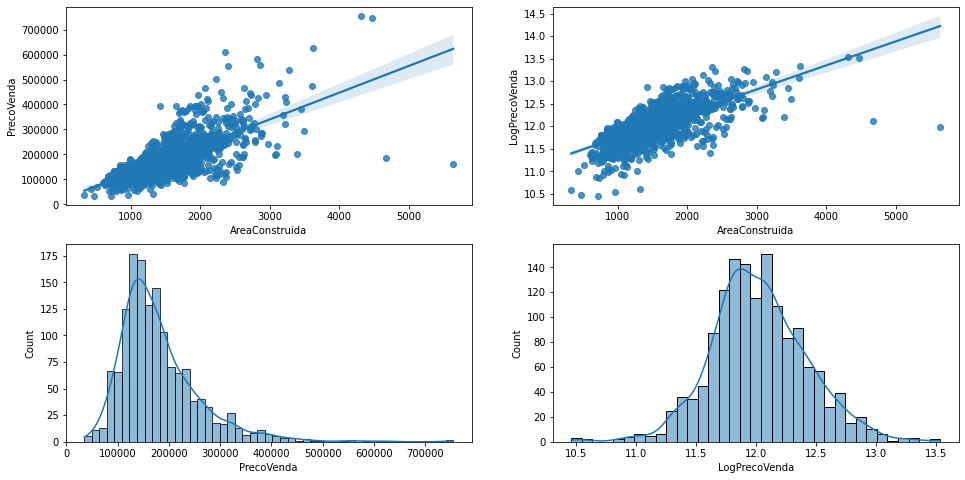

In [ ]:
fig, axs = plt.subplots(figsize=(16,8), ncols=2, nrows=2)

sns.histplot(x=data.PrecoVenda, kde=True, ax=axs[1][0])
sns.histplot(x=data.LogPrecoVenda, kde=True, ax=axs[1][1])

sns.regplot(x='AreaConstruida', y='PrecoVenda', data=data, ax=axs[0][0])
sns.regplot(x='AreaConstruida', y='LogPrecoVenda', data=data, ax=axs[0][1])

plt.show()

In [ ]:
#Função para retirar os 5% inferiores e superiores
#P = np.percentile(data.PrecoVenda, [5, 95])
#data = data[(data.PrecoVenda > P[0]) & (data.PrecoVenda < P[1])]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


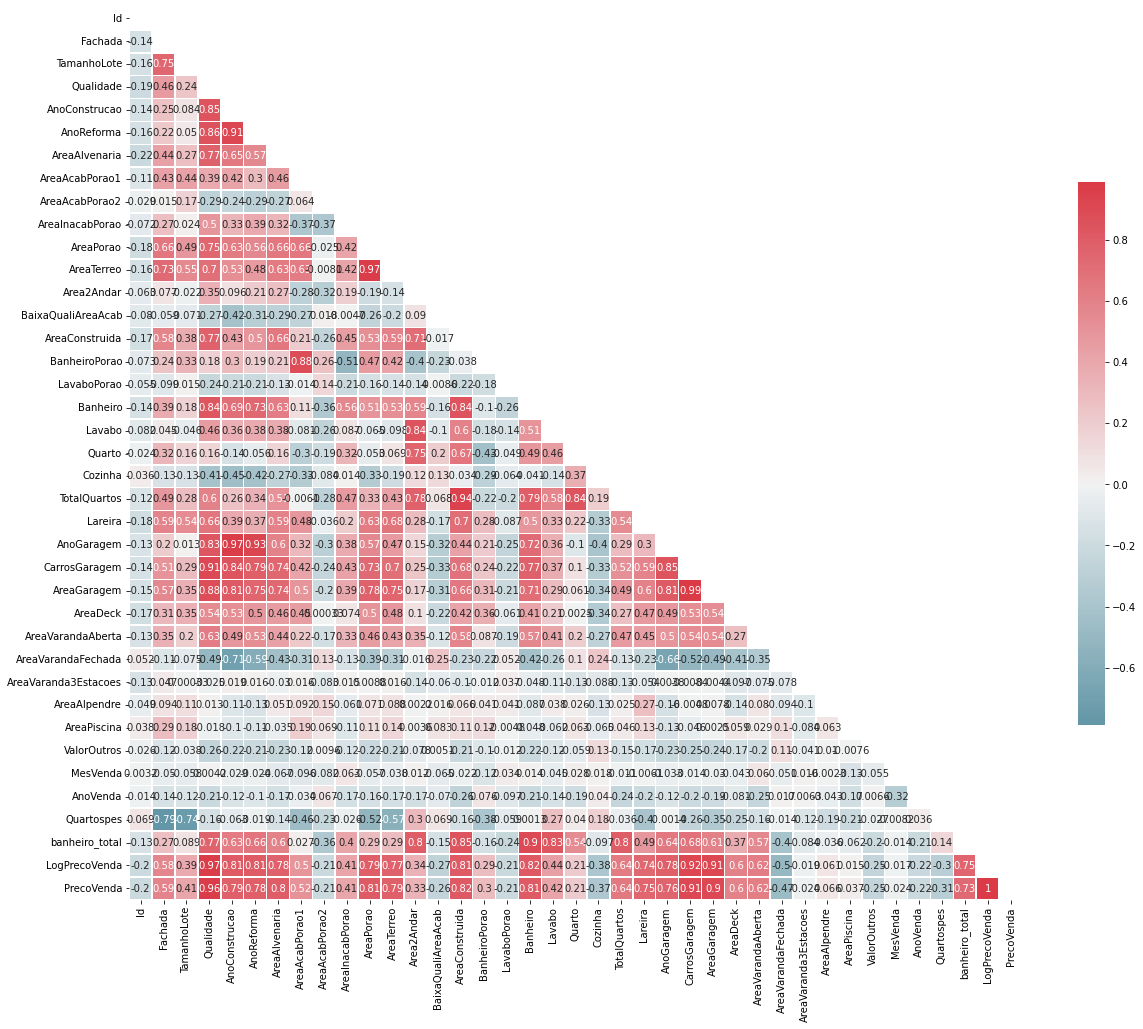

In [ ]:
corr_matrix = data[num_vars + [target]].corr()
plot_corr_matrix(corr_matrix)

In [ ]:
corr_matrix[target].sort_values(ascending=False)

PrecoVenda              1.000000
LogPrecoVenda           0.948374
Qualidade               0.790982
AreaConstruida          0.708624
CarrosGaragem           0.640409
AreaGaragem             0.623431
AreaPorao               0.613581
AreaTerreo              0.605852
banheiro_total          0.568267
Banheiro                0.560664
TotalQuartos            0.533723
AnoConstrucao           0.522897
AnoReforma              0.507101
AnoGaragem              0.486362
AreaAlvenaria           0.477493
Lareira                 0.466929
AreaAcabPorao1          0.386420
Fachada                 0.351799
AreaDeck                0.324413
Area2Andar              0.319334
AreaVarandaAberta       0.315856
Lavabo                  0.284108
TamanhoLote             0.263843
BanheiroPorao           0.227122
AreaInacabPorao         0.214479
Quarto                  0.168213
AreaAlpendre            0.111447
AreaPiscina             0.092404
MesVenda                0.046432
AreaVaranda3Estacoes    0.044584
AreaAcabPo

In [ ]:
corrMatrix = data.corr(method='pearson')
vet_corr = corrMatrix.unstack()
maior_corr = vet_corr.where((vet_corr >= 0.5) & (vet_corr < 1)).dropna().sort_values(kind="quicksort", ascending=False)
menor_corr = vet_corr.where((vet_corr <= -0.5) & (vet_corr > -1)).dropna().sort_values(kind="quicksort", ascending=False)
escolha = maior_corr.append(menor_corr).index
correlacao = []
for item in escolha[:][:]:
    if item[0] == 'LogPrecoVenda':
        correlacao.append(item[1])

In [ ]:
correlacao

['PrecoVenda',
 'Qualidade',
 'AreaConstruida',
 'CarrosGaragem',
 'AreaGaragem',
 'AreaPorao',
 'banheiro_total',
 'AreaTerreo',
 'Banheiro',
 'AnoConstrucao',
 'AnoReforma',
 'AnoGaragem',
 'TotalQuartos']

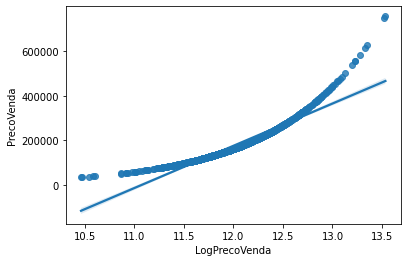

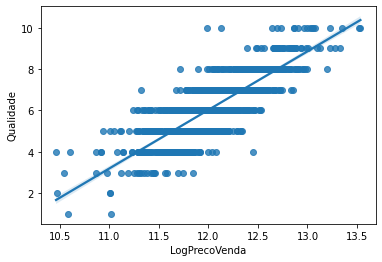

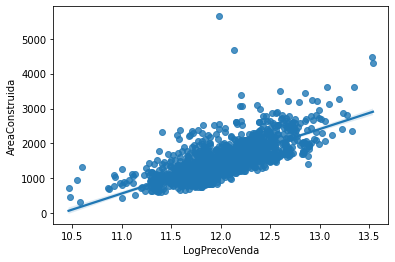

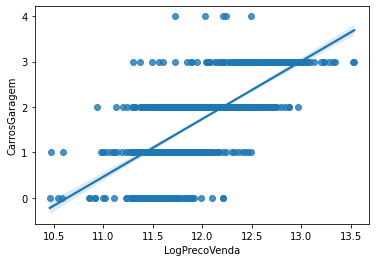

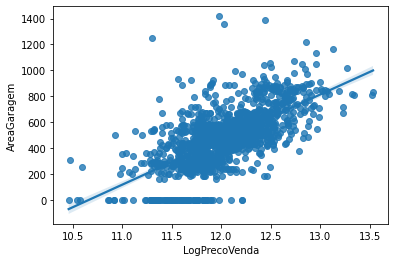

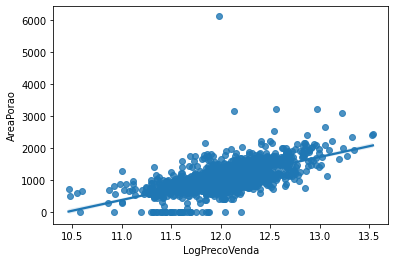

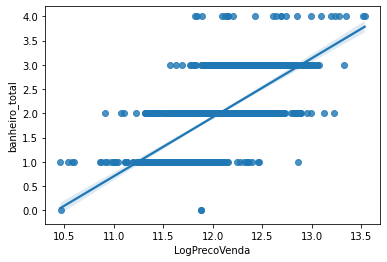

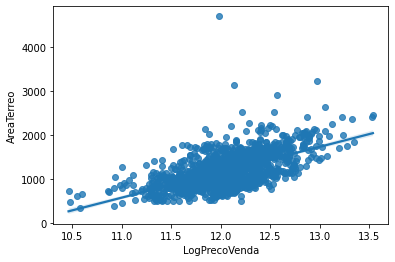

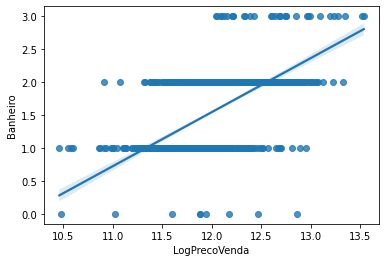

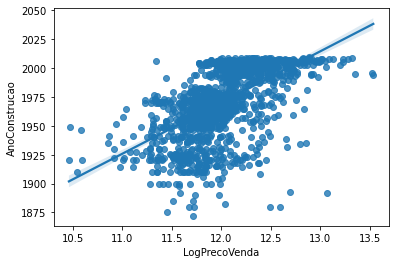

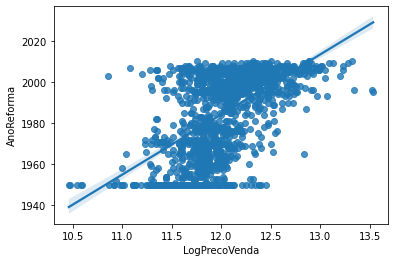

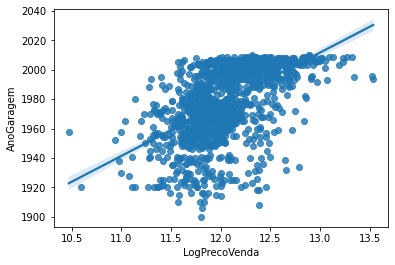

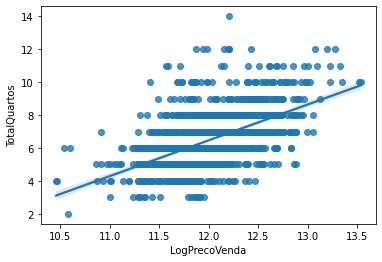

In [ ]:
for name in correlacao:
    sns.regplot(x=data['LogPrecoVenda'], y=data[name])
    plt.show()

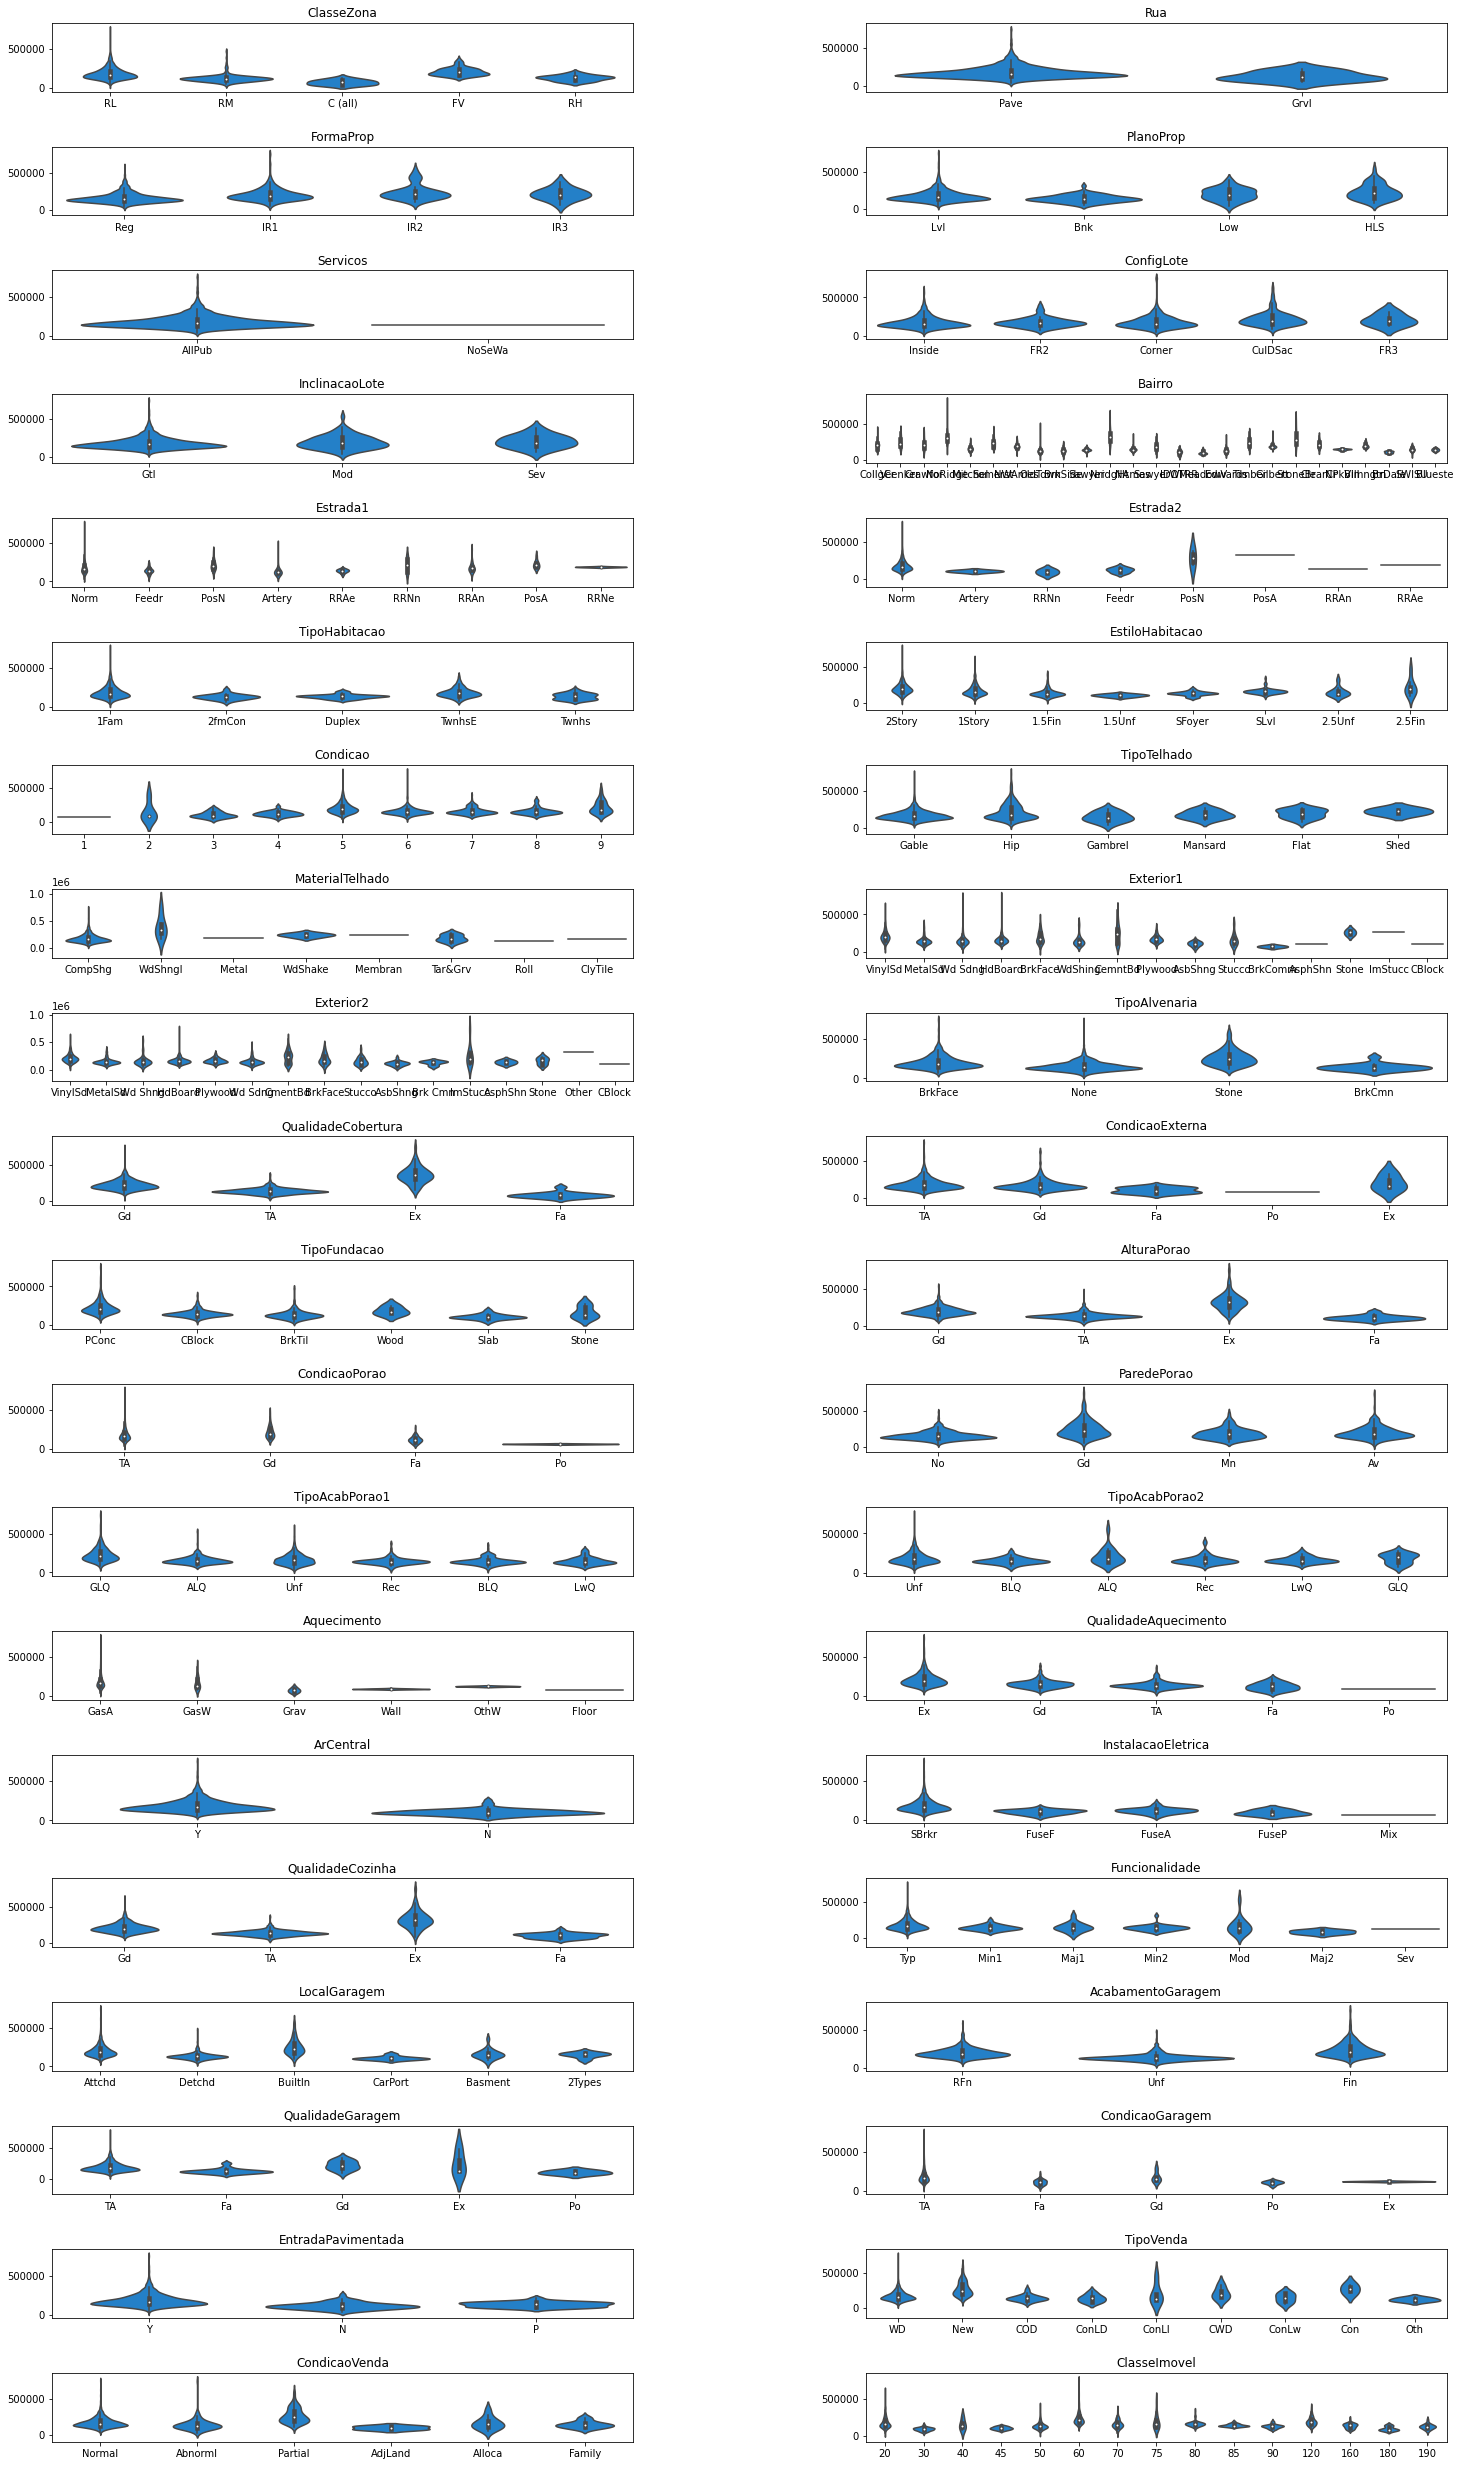

In [ ]:
# Configurando a figura do matplot lib
fig = plt.figure(figsize=(25,90))
fig.subplots_adjust(hspace=0.8, wspace=0.4)

total_plots = len(cat_vars)
i = 0
# Iterando para todas variaveis categoricas
for var in cat_vars:
    # Pegando o index certo para plotar o grafico
    ax = fig.add_subplot(total_plots, 2, i+1)
    # Desenhando o grafico do tipo violinplot
    sns.violinplot(x=var, y=target, color='#0984e3', title=var,data=data, ax=ax)
    ax.set_title(var)
    ax.set_ylabel('')
    ax.set_xlabel('')
    i += 1

plt.show()

 Vemos relação entre a lista de correlação com a variável alvo, então pode ser um bom indício para o modelo de regressão linear.
 
 Também vemos um relação direta entre Qualidade e a variável alvo. Outras variáveis possíveis para teste é a condição/ FormaProp/ PlanoProp.

# OBJETIVO 1 - INTERPRETABILIDADE USANDO UMA REGRESSÃO LINEAR

In [ ]:
numerics = ['int64', 'float64']
numerical = list(data.select_dtypes(include=numerics).columns)
data_reg = data[numerical]

In [ ]:
x = data_reg.drop(['PrecoVenda','LogPrecoVenda', 'Id'], axis = 1)
x

,ClasseImovel,Fachada,TamanhoLote,Qualidade,AnoConstrucao,AnoReforma,AreaAlvenaria,AreaAcabPorao1,AreaAcabPorao2,AreaInacabPorao,...,AreaVarandaAberta,AreaVarandaFechada,AreaVaranda3Estacoes,AreaAlpendre,AreaPiscina,ValorOutros,MesVenda,AnoVenda,Quartospes,banheiro_total
0,60,65.0,8450,7,2003,2003,196.0,706,0,150,...,61,0,0,0,0,0,2,2008,0.000947,3
1,20,80.0,9600,6,1976,1976,0.0,978,0,284,...,0,0,0,0,0,0,5,2007,0.000625,2
2,60,68.0,11250,7,2001,2002,162.0,486,0,434,...,42,0,0,0,0,0,9,2008,0.000533,3
3,70,60.0,9550,7,1915,1970,0.0,216,0,540,...,35,272,0,0,0,0,2,2006,0.000733,1
4,60,84.0,14260,8,2000,2000,350.0,655,0,490,...,84,0,0,0,0,0,12,2008,0.000631,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,1999,2000,0.0,0,0,953,...,40,0,0,0,0,0,8,2007,0.000884,3
1456,20,85.0,13175,6,1978,1988,119.0,790,163,589,...,0,0,0,0,0,0,2,2010,0.000531,2
1457,70,66.0,9042,7,1941,2006,0.0,275,0,877,...,60,0,0,0,0,2500,5,2010,0.000995,2
1458,20,68.0,9717,5,1950,1996,0.0,49,1029,0,...,0,112,0,0,0,0,4,2010,0.000515,1


In [ ]:
y = data_reg['LogPrecoVenda']

In [ ]:
mi = mutual_info_regression(x.fillna(0), y)
mi

array([2.82416509e-01, 2.05616156e-01, 1.69903573e-01, 5.67168048e-01,
       3.61685302e-01, 2.36507473e-01, 8.97670782e-02, 1.44445100e-01,
       5.30713680e-03, 1.27410971e-01, 3.61821433e-01, 3.00002546e-01,
       2.00244094e-01, 6.61606203e-03, 4.56095899e-01, 2.43280039e-02,
       8.80687928e-03, 2.63686743e-01, 9.08576322e-02, 7.28731114e-02,
       2.30283876e-02, 2.13101824e-01, 1.65845099e-01, 2.54463843e-01,
       3.65484253e-01, 3.62192490e-01, 1.00036759e-01, 1.59589139e-01,
       2.36797567e-02, 7.60459560e-05, 1.69087079e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.88245746e-03, 5.15668910e-02,
       2.94865009e-01])

In [ ]:
mi = pd.Series(mi)
mi.index = x.columns
mi = mi.sort_values(ascending = False)


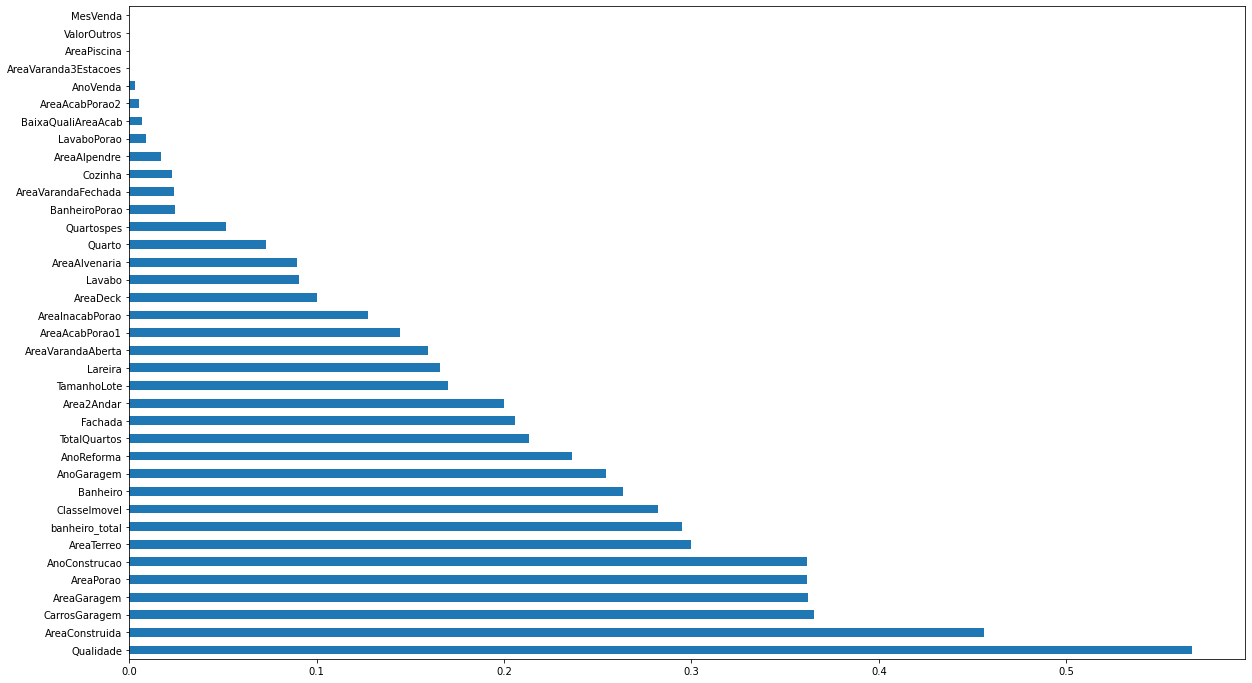

In [ ]:
mi.plot.barh(figsize=(20,12))

In [ ]:
sel_ = SelectKBest(mutual_info_regression, k = 10).fit(x.fillna(0), y)
x.columns[sel_.get_support()]

Index(['ClasseImovel', 'Qualidade', 'AnoConstrucao', 'AreaPorao', 'AreaTerreo',
       'AreaConstruida', 'Banheiro', 'CarrosGaragem', 'AreaGaragem',
       'banheiro_total'],
      dtype='object')

In [ ]:
list(x.columns[sel_.get_support()])

['ClasseImovel',
 'Qualidade',
 'AnoConstrucao',
 'AreaPorao',
 'AreaTerreo',
 'AreaConstruida',
 'Banheiro',
 'CarrosGaragem',
 'AreaGaragem',
 'banheiro_total']

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
mod1 = smf.ols(formula = 'LogPrecoVenda ~ ClasseImovel + AnoConstrucao +  AreaPorao + AreaTerreo + \
                CarrosGaragem + AreaGaragem + banheiro_total', data = data)
res = mod1.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:          LogPrecoVenda   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     545.2
Date:                Wed, 27 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:43:38   Log-Likelihood:                 209.49
No. Observations:                1460   AIC:                            -403.0
Df Residuals:                    1452   BIC:                            -360.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.2809      0.454     16.

In [ ]:
correlacao

['PrecoVenda',
 'Qualidade',
 'AreaConstruida',
 'CarrosGaragem',
 'AreaGaragem',
 'AreaPorao',
 'banheiro_total',
 'AreaTerreo',
 'Banheiro',
 'AnoConstrucao',
 'AnoReforma',
 'AnoGaragem',
 'TotalQuartos']

In [ ]:
#Discretizando a variavel sexo com OneHotEncoder
PlanoProp = OneHotEncoder().fit_transform(data[['PlanoProp']]).toarray() #Codifica a variavel de n niveis em n variaveis
PlanoProp = pd.DataFrame(PlanoProp) #Transforma essas novas variaveis em um dataframe
PlanoProp.rename(columns = {0:'Lvl', 1:'Bnk', 2:'HLS', 3:'Low'}, inplace = True) #Atribui nome pra identificação
data = pd.concat([data, PlanoProp], axis=1, join='inner') #Concatena o banco o original com as variaveis criadas na codificação

data = pd.get_dummies(data, columns=['ArCentral'], drop_first=True)

data

,Id,ClasseImovel,ClasseZona,Fachada,TamanhoLote,Rua,FormaProp,PlanoProp,Servicos,ConfigLote,...,CondicaoVenda,PrecoVenda,Quartospes,banheiro_total,LogPrecoVenda,Lvl,Bnk,HLS,Low,ArCentral_Y
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,Normal,208500,0.000947,3,12.247694,0.0,0.0,0.0,1.0,1
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,Normal,181500,0.000625,2,12.109011,0.0,0.0,0.0,1.0,1
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,Normal,223500,0.000533,3,12.317167,0.0,0.0,0.0,1.0,1
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,Abnorml,140000,0.000733,1,11.849398,0.0,0.0,0.0,1.0,1
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,Normal,250000,0.000631,3,12.429216,0.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,...,Normal,175000,0.000884,3,12.072541,0.0,0.0,0.0,1.0,1
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,...,Normal,210000,0.000531,2,12.254863,0.0,0.0,0.0,1.0,1
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,...,Normal,266500,0.000995,2,12.493130,0.0,0.0,0.0,1.0,1
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,...,Normal,142125,0.000515,1,11.864462,0.0,0.0,0.0,1.0,1


In [ ]:
#verificando as variáveis salvas na lista correlação
mod = smf.ols(formula = 'LogPrecoVenda ~ AreaConstruida + AreaPorao + \
                        banheiro_total  + Qualidade\
                        + CarrosGaragem + ArCentral_Y ', data = data)
mod_fit = mod.fit()
print(mod_fit.summary())


                            OLS Regression Results                            
Dep. Variable:          LogPrecoVenda   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     1336.
Date:                Wed, 27 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:46:05   Log-Likelihood:                 635.82
No. Observations:                1458   AIC:                            -1258.
Df Residuals:                    1451   BIC:                            -1221.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         10.4054      0.022    469.

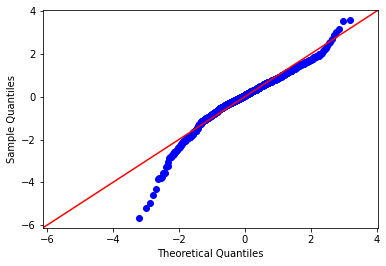

Statistics=639.412, p=0.000
Sample does not look Gaussian (reject H0)


In [ ]:
from scipy import stats
from scipy.stats import shapiro, jarque_bera

# GRÁFICO QQ - NORMALIDADE #

modelo_residuo = mod_fit.resid
modelo_y_ajustado = mod_fit.fittedvalues

sm.qqplot(modelo_residuo, line="45", fit=True,dist=stats.norm)
plt.show()

#Teste Shapiro-Wilk para normalidade dos residuos
stat, p = jarque_bera(modelo_residuo)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpretação
alpha = 0.05
if p > alpha:print('Sample looks Gaussian (fail to reject H0)')
else:print('Sample does not look Gaussian (reject H0)')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


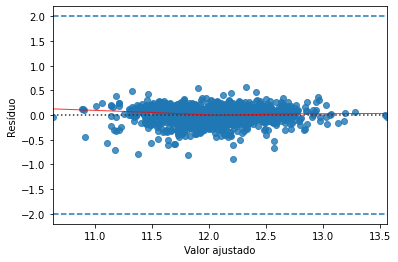

In [ ]:
# GRÁFICO PARA LINEARIDADE E HOMOCEDASTICIDADE #
# O que tirar do conclusão do gráfico? Como interpretar?

sns.residplot(modelo_y_ajustado, modelo_residuo, 
                          lowess=True,
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.axhline(y = 2, linestyle='dashed')
plt.axhline(y = -2, linestyle='dashed')
plt.ylabel('Resíduo')
plt.xlabel('Valor ajustado')
plt.show()

In [ ]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_white


#Testes de Heterocedasticidade

#Breush-Pagan test:
# se P < 0.05 homocedasticidade Rejeitada - logo Heterocedastico

name = ["Breusch pagan statistic", "p-value"]
test = sms.het_breuschpagan(modelo_residuo, mod_fit.model.exog)
print(lzip(name, test))
print()

#Goldfeld-Quandt test
# se P < 0.05 homocedasticidade Rejeitada - logo Heterocedastico

name = ["Goldfeld-Quandt - statistic", "p-value"]
test = sms.het_goldfeldquandt(modelo_residuo, mod_fit.model.exog)
print(lzip(name, test))
print()


[('Breusch pagan statistic', 64.43173180793828), ('p-value', 5.634843074274782e-12)]

[('Goldfeld-Quandt - statistic', 0.8204659692901031), ('p-value', 0.9960402042572297)]



In [ ]:
from statsmodels.graphics.regressionplots import *

#https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.OLSInfluence.html#statsmodels.stats.outliers_influence.OLSInfluence
    
influence = mod_fit.get_influence()
inf_sum = influence.summary_frame().round(3)

#Algumas métricas de avaliação de de pontos influentes.
print(inf_sum.sample())

     dfb_Intercept  dfb_AreaConstruida  dfb_AreaPorao  dfb_banheiro_total  \
793          0.004               0.004         -0.003                 0.0   

     dfb_Qualidade  dfb_CarrosGaragem  dfb_ArCentral_Y  cooks_d  \
793         -0.007              0.003            0.001      0.0   

     standard_resid  hat_diag  dffits_internal  student_resid  dffits  
793          -0.185     0.003            -0.01         -0.185   -0.01  


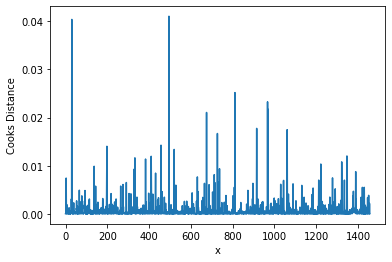

In [ ]:
#Avaliação da Distancia de Coock para identificar pontos influentes
cooks = influence.cooks_distance
X = data[['Qualidade']]

plt.plot(cooks[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

In [ ]:
arr = cooks[0] > 0.05
data.drop(data[arr].index, axis = 0, inplace = True)
#REMOVENDO PONTOS QUE INFLUÊNCIAM NO MODELO DE REGRESSÃO
#CASO EXECUTE NOVAMENTE A REGRESSÃO LINEAR VERÁ QUE HÁ MELHORA TANTO NO R² QUANTO NO VALOR DE P EM QUALIDADE[T10]

In [ ]:
round((np.exp(mod_fit.params[1:]) - 1)*100, 2)

AreaConstruida     0.02
AreaPorao          0.02
banheiro_total     4.21
Qualidade         11.04
CarrosGaragem      9.29
ArCentral_Y       22.83
dtype: float64

# OBJETIVO 2 - PODER PREDITIVO, REGRESSÃO VIA RANDOM FOREST E REGRESSÃO LINEAR DO SKNLEARN



In [ ]:
#selecionando os dados segundo a regressão no objetivo 1
olsData = data[['AreaConstruida' , 'AreaPorao' , \
               'Qualidade' , 'banheiro_total',\
               'CarrosGaragem', 'PrecoVenda']]
features = ['AreaConstruida' , 'AreaPorao' , \
               'Qualidade' , 'banheiro_total',\
               'CarrosGaragem', 'PrecoVenda']

In [ ]:
(
  X_train, X_test, 
  X_val, y_train, 
  y_test, y_val
) = train_test_valid_split(olsData, target='PrecoVenda', test_size=0.3, valid_size=0.5, random_state=42)

### Split Data

In [ ]:
regr = LinearRegression(fit_intercept = False)
regr.fit(X_train, y_train, sample_weight = 500)

LinearRegression(fit_intercept=False)

## Regressão Linear

### Train

In [ ]:
regr.score(X_train, y_train)

0.8361470251165579

In [ ]:
y_val_baseline_pred = regr.predict(X_train)
baseline_report_train = metrics_report(y_train, y_val_baseline_pred, 'Train')
baseline_report_train

,metric,Train
0,RMSE,0.16
1,MAE,0.12
2,R^2,0.84
3,MAPE,0.01
4,Avg. target,12.03
5,Avg. Prediction,12.03


### Test

In [ ]:
array = regr.predict(X_test)

In [ ]:
regr.score(X_test, y_test)

0.8300707965124821

In [ ]:
y_val_baseline_pred = regr.predict(X_test)
baseline_report_test = metrics_report(y_test, y_val_baseline_pred, 'Test')

,metric,Test
0,RMSE,0.17
1,MAE,0.12
2,R^2,0.83
3,MAPE,0.01
4,Avg. target,12.05
5,Avg. Prediction,12.05


### Validation

In [ ]:
regr.score(X_valid, y_valid)

0.8305682451569317

In [ ]:
validation = regr.predict(X_valid)

In [ ]:
y_val_baseline_pred = regr.predict(X_valid)
baseline_report_valid = metrics_report(y_valid, y_val_baseline_pred, 'Validation')

### Random Forest

In [ ]:
resume = baseline_report_train.merge(baseline_report_test, how='inner', on='metric')
resume = resume.merge(baseline_report_valid, how='inner', on='metric')

In [ ]:
resume

,metric,Train,Test,Validation
0,RMSE,0.16,0.17,0.16
1,MAE,0.12,0.12,0.12
2,R^2,0.84,0.83,0.83
3,MAPE,0.01,0.01,0.01
4,Avg. target,12.03,12.05,11.98
5,Avg. Prediction,12.03,12.05,11.98


## Random Forest Regressor

In [ ]:
RFregr = RandomForestRegressor(max_depth=2, max_features = 0.6, min_samples_leaf = 15, n_estimators = 200)

In [ ]:
RFregr.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, max_features=0.6, min_samples_leaf=15,
                      n_estimators=200)

### Train

In [ ]:
RFregr.score(X_train, y_train)

0.7208204187849839

In [ ]:
y_val_baseline_pred = regr.predict(X_train)
baseline_report_train = metrics_report(y_train, y_val_baseline_pred, 'Train')


### Test

In [ ]:
RFregr.score(X_test, y_test)

0.7099368123678127

In [ ]:
y_val_baseline_pred = regr.predict(X_test)
baseline_report_test = metrics_report(y_test, y_val_baseline_pred, 'Test')

### Validation

In [ ]:
RFregr.score(X_valid, y_valid)

0.7246715629658275

In [ ]:
y_val_baseline_pred = regr.predict(X_valid)
baseline_report_valid = metrics_report(y_valid, y_val_baseline_pred, 'Validation')

### Resultados Random Forest

In [ ]:
resume = baseline_report_train.merge(baseline_report_test, how='inner', on='metric')
resume = resume.merge(baseline_report_valid, how='inner', on='metric')

In [ ]:
resume

,metric,Train,Test,Validation
0,RMSE,0.16,0.17,0.16
1,MAE,0.12,0.12,0.12
2,R^2,0.84,0.83,0.83
3,MAPE,0.01,0.01,0.01
4,Avg. target,12.03,12.05,11.98
5,Avg. Prediction,12.03,12.05,11.98


## Importancia das Features

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html
print('Running permutation feature importance')
permutation_result = permutation_importance(RFregr, X_valid, y_valid, n_repeats=5, random_state=42)

Running permutation feature importance


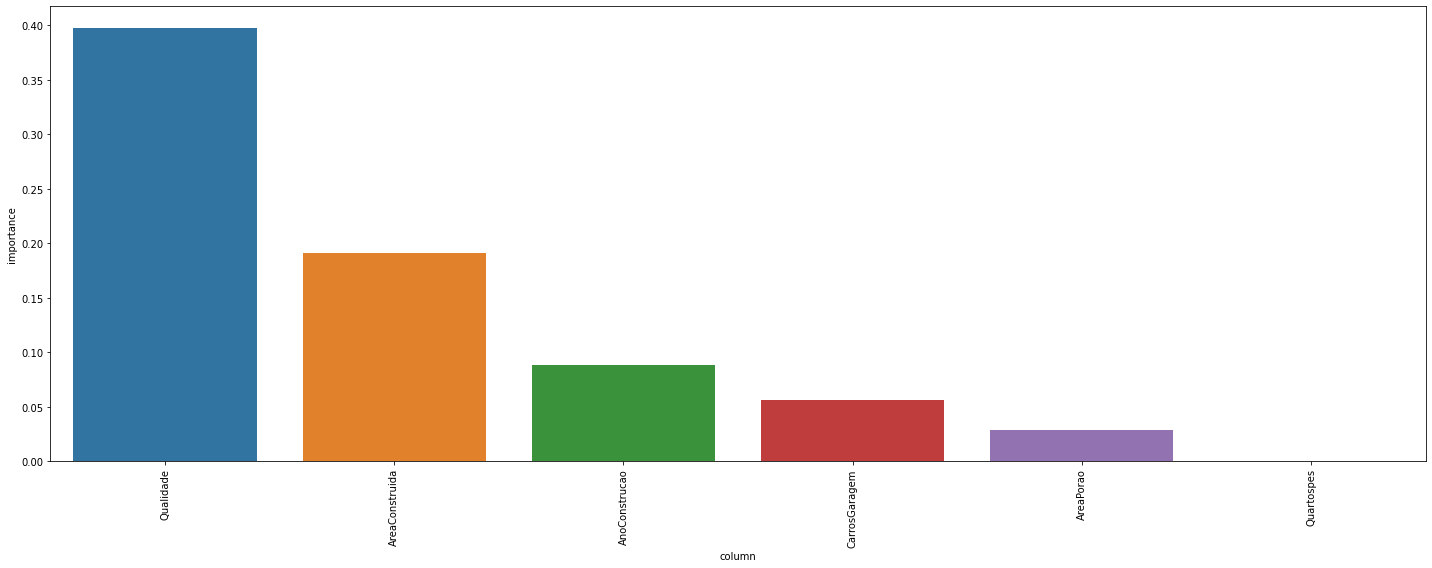

In [ ]:
importances = pd.DataFrame({'column' : X_valid.columns, 'importance': permutation_result.importances_mean})
importances.sort_values(by='importance', ascending=False, inplace=True)

fig, axs = plt.subplots(figsize=(20,8))
ax = sns.barplot(x='column', y="importance", data=importances)
plt.xticks(rotation=90)
plt.tight_layout()

In [ ]:
# Getting the top 40 best features
best_features = importances.head(25).column.tolist()
print(best_features)

['Qualidade', 'AreaConstruida', 'AnoConstrucao', 'CarrosGaragem', 'AreaPorao', 'Quartospes']


In [ ]:
# Fitting the final RandomForest model
rf_model = RandomForestRegressor(n_estimators=150, max_features=0.3, min_samples_leaf= 1, random_state=42)
rf_model.fit(X_train[best_features], y_train)

# Computing predictions
y_train_pred = rf_model.predict(X_train[best_features])
y_val_pred = rf_model.predict(X_valid[best_features])
y_test_pred = rf_model.predict(X_test[best_features])

# Computing the train, validation and test model performance metrics
train_report = metrics_report(y_train, y_train_pred, 'train')
val_report = metrics_report(y_valid, y_val_pred, 'validation')
test_report = metrics_report(y_test, y_test_pred, 'test')

final_report = pd.concat([train_report, val_report[['validation']],  test_report[['test']]], axis=1)

print(f'Baseline report (total features: {len(data.columns)})')
print('')
print(f'Final report (total features: {len(best_features)})')
print(final_report)

Baseline report (total features: 83)

Final report (total features: 6)
            metric  train  validation   test
0             RMSE   0.06        0.14   0.17
1              MAE   0.04        0.10   0.11
2              R^2   0.98        0.86   0.83
3             MAPE   0.00        0.01   0.01
4      Avg. target  12.03       11.98  12.05
5  Avg. Prediction  12.03       11.98  12.05


Running permutation feature importance with the final model on the held-out testing set


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed d

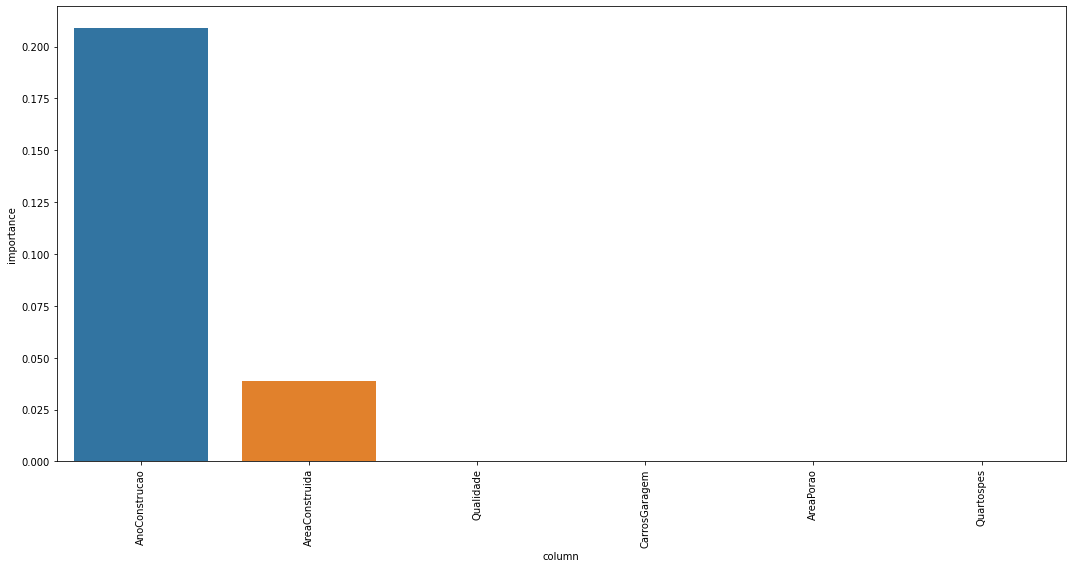

In [ ]:
print('Running permutation feature importance with the final model on the held-out testing set')
permutation_result = permutation_importance(RFregr, X_test[best_features], y_test, n_repeats=5, random_state=42)

importances = pd.DataFrame({'column' : X_test[best_features].columns, 'importance': permutation_result.importances_mean})
importances.sort_values(by='importance', ascending=False, inplace=True)

fig, axs = plt.subplots(figsize=(15,8))
ax = sns.barplot(x='column', y="importance", data=importances)
plt.xticks(rotation=90)
plt.tight_layout()